# Conditional GAN for MNIST

A conditional GAN learns a separate “image manifold” for each class while still sharing parameters across classes. You tell the Generator which digit to generate (0–9) via a label y, and it maps (noise z, label y) to an image X that should look like a real MNIST digit of class y.

Conceptually, each label carves the latent space into a family of submanifolds: change z to vary style within the class; change y to switch class.

## Setup & Import
- import torch + numpy + other libs needed
- get current device

In [1]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Data (MNIST, handwritten digits 0–9)

Load MNIST dataset and create a dataloader. The dataloader should include a **preprocessing pipeline** for the images in the dataset that:

- convert each MNIST image (which comes as a PIL image) into a PyTorch tensor, with pixel values scaled from [0, 255] to [0, 1] --> use toTensor()
- rescale those values from [0, 1] to [-1, 1] (which is the range expected by the neural network) --> use Normalize((0.5,), (0.5,)). Formula: (x - mean) / std -> (x - 0.5) / 0.5.

Data loader requires as well the **MNIST dataset** (dataset.MNIST). Parameters:
- root="./data" -> where to store the dataset locally.
- train=True -> load the training split (60,000 images).
- download=True -> automatically download the dataset if it’s not already in ./data.
- transform=transform -> apply the preprocessing pipeline defined (tensor conversion + normalization).

Now you can **wrap the dataset in a DataLoader**, which handles batching, shuffling, and loading data efficiently. Parameters:
- trainset
- batch_size
- shuffle=True -> randomly shuffles the dataset each epoch (important so the model doesn’t see the data in the same order every time).
- num_workers=2 -> uses 2 subprocesses to load data in parallel, speeding up data loading.
- pin_memory=True -> allows faster data transfer to GPU if available.



In [ ]:
batch_size = 32

# create data processing pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # -> [-1, 1]
])

# load and store locally the dataset
trainset = datasets.MNIST(root="../data/MNIST", train=True, download=True, transform=transform)
print('Total images', len(trainset))

# create the dataloader
loader   = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
print('number of batches per epoch (total images ÷ batch size)', len(loader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.74MB/s]

Total images 60000
number of batches per epoch (total images ÷ batch size) 1875


## Models (Generator e Discriminator with simple MLPs)

Again let's take the simplest option (using MLPs for both generator and discriminator).

### GENERATOR
The Generator takes a random noise vector (latent code, size = 100) which is chained with a one hot vector representing the class as input and transforms it into an image shaped like the MNIST digit requested by the class (28×28 pixels, grayscale).

#### How the input is formed

Noise vector z provides randomness -> controls style variations of the generated digit (slant, thickness, stroke, etc.).

Label y is converted to a one-hot vector of length 10 (digit “3” → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]) -> tells the Generator which class of digit it should produce.

Noise and label are joined along the feature dimension and passed to the first linear layer. The rest of phyolosophy for building the model is the same as seen before.

In [3]:
# dimension of the latent space
z_dim    = 100

# number of classes to be controlled
num_classes = 10

# -----------------------
# Conditional Generator
# -----------------------
class Generator(nn.Module):
    """
    Input:  z ~ N(0,1) of shape [B, z_dim]
            y_onehot of shape [B, num_classes]
    Output: fake image in [-1, 1], shape [B, 1, 28, 28]
    """
    def __init__(self, z_dim, num_classes):
        super().__init__()
        in_dim = z_dim + num_classes
        self.net = nn.Sequential(

            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, y_onehot):
        x = torch.cat([z, y_onehot], dim=1)     # [B, z_dim + C]
        x = self.net(x)                         # [B, 784]
        return x.view(-1, 1, 28, 28)

# -----------------------

### DISCRIMINATOR
The discriminator is  a binary classifier: given an image, it predicts how likely it is to be real (from MNIST) vs fake (from the Generator).

As for the generator, the input image should be concatenated with the class label (flatten the image + concatenate the one-hot class vector).

As before, we huse BCEWithLogits as loss, so let teh model oupt the logits

In [6]:


# -----------------------
# Conditional Discriminator
# -----------------------
class Discriminator(nn.Module):
    """
    Input:  x image in [-1,1], shape [B, 1, 28, 28]
            y_onehot of shape [B, num_classes]
    Output: logits, shape [B]
    """
    def __init__(self, num_classes):
        super().__init__()
        in_dim = 28*28 + num_classes
        self.net = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_dim, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1)
        )

    def forward(self, x, y_onehot):
        b = x.size(0)
        # flatten images and concatenate with one hot labels
        flat = x.view(b, -1)                    # [B, 784]
        inp = torch.cat([flat, y_onehot], dim=1)# [B, 784 + C]
        return self.net(inp).view(-1)           # [B]

# create generator, discrimintaor and count their parameters
G = Generator(z_dim, num_classes).to(device)
D = Discriminator(num_classes).to(device)
print('Generator parameters =', sum(p.numel() for p in G.parameters()),
       '\nDiscriminator parameters =', sum(p.numel() for p in D.parameters()))

Generator parameters = 1388816 
Discriminator parameters = 1339393


## Loss, and optimizers (and utilities...)

As loss, we use BCEWithLogitsLoss(), Adam as optimizers (use the same parameters as for unconditional generation), and again label smoothing.

Finally, create a set of fixed latent codes to visualize generation progresses (10 columns of 8 digits).


In [7]:
# we take the option of using BCEWithLogits as loss...
criterion = nn.BCEWithLogitsLoss()

# creating the optimizers
optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

real_label = 0.9   # label smoothing
fake_label = 0.0

# -----------------------
# One-hot helper
# -----------------------
def to_onehot(y, num_classes, device):
    # y: LongTensor of shape [B]
    return F.one_hot(y, num_classes=num_classes).float().to(device)


# -----------------------
# Fixed noise & labels for monitoring
# (8 samples per class -> 80 total, or keep 64 if you prefer)
# -----------------------
torch.manual_seed(0)
n_per_class = 8
fixed_y = torch.arange(num_classes).repeat(n_per_class).to(device)  # 0..9, 0..9, ... (8 volte)
fixed_y_onehot = to_onehot(fixed_y, num_classes, device)
fixed_z = torch.randn(fixed_y.size(0), z_dim, device=device)

# create an output directory to save generated images for later use...
os.makedirs("samples", exist_ok=True)

def show_grid(tensor, title=None, nrow=10):
    # nrow=10 to group by class nicely
    imgs = (tensor.clamp(-1,1) + 1)/2
    grid = utils.make_grid(imgs, nrow=nrow, padding=2, normalize=False)
    npimg = grid.detach().cpu().numpy()
    plt.figure(figsize=(10,8))
    plt.axis("off")
    if title: plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap="gray")
    plt.show()

## Training loop

Training is a two-player game:
- the Generator maps random noise and class label to fake MNIST images corresponding to the indicated label
- the Discriminator receives an image and its label and outputs a score (logit) for real vs fake.

At each iteration:
- Update D, by using real images from dataloader + fake images from the generator (G is not updated in this step)
- Update G, by using fake images only (D is not updated in this step)

You repeat this over multiple epochs. As D improves at spotting fakes, G is pushed to produce more realistic digits; as G improves, D must refine its decision boundary.

NOTE: take care that the number of batch images may be smaller than the batch size for the last batch... compute the real batch size at each iteration



Saved: samples/epoch_10_cgan.png


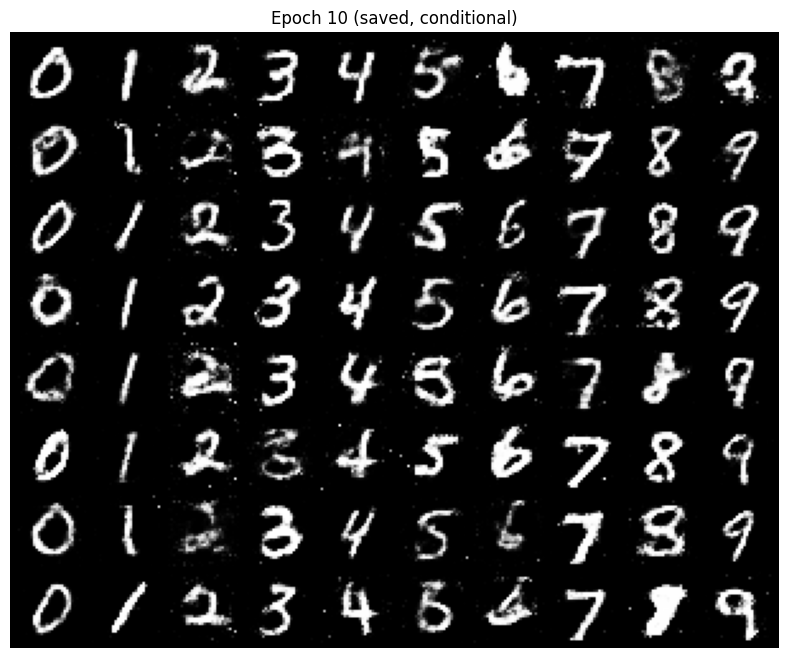

In [10]:
epochs = 10

for epoch in range(1, epochs+1):
    for i, (real, y) in enumerate(loader):
        real = real.to(device)
        y = y.to(device)
        y_onehot = to_onehot(y, num_classes, device)
        b = real.size(0)
        z = torch.randn(b, z_dim, device=device)

        # ======== Update D ========
        # put D in training mode and clear its gradient
        D.train()
        optD.zero_grad()

        # 1. feed real images into D
        real_logits = D(real, y_onehot)
        real_labels = torch.full((b,), real_label, device=device)
        loss_D_real = criterion(real_logits, real_labels)


        # 2. feed fake images into D (stop gradient through G)
        with torch.no_grad():
            fake = G(z, y_onehot)
        fake_logits = D(fake, y_onehot)
        fake_labels = torch.full((b,), fake_label, device=device)
        loss_D_fake = criterion(fake_logits, fake_labels)

        # 3. compute loss and backprop for D
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optD.step()

        # ======== Update G ========
        # put G intraining mode and zero its gradient
        G.train()
        optG.zero_grad()

        # 1. feed fake images into D
        fake = G(z, y_onehot)
        fake_logits = D(fake, y_onehot)

        # 2. compute loss and backprop for G
        loss_G = criterion(fake_logits, real_labels)
        loss_G.backward()
        optG.step()

        # ======== logging ========
        # log each 200 steps and show progress
        if (i % 200 == 0):
            clear_output(wait=True)
            print(f"[{epoch:02d}/{epochs:02d}] step {i:04d} | loss_D={loss_D.item():.3f}  loss_G={loss_G.item():.3f}")
            with torch.no_grad():
                G.eval()
                preview = G(fixed_z, fixed_y_onehot)
            show_grid(preview, title=f"Epoch {epoch} | Step {i} (by class rows)", nrow=num_classes)


    # epoch end: save a grid on disk and show progress
    with torch.no_grad():
        G.eval()
        preview = G(fixed_z, fixed_y_onehot)

    # before saving images, denormalizes them in [0,1]
    utils.save_image((preview+1)/2, f"samples/epoch_{epoch:02d}_cgan.png", nrow=num_classes)
    clear_output(wait=True)
    print(f"Saved: samples/epoch_{epoch:02d}_cgan.png")
    show_grid(preview, title=f"Epoch {epoch} (saved, conditional)", nrow=num_classes)